<a href="https://colab.research.google.com/github/ismailazdad/uwmgit/blob/main/Unet_working_example4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [ ]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2 # 1..5

In [ ]:
!rm -rf /content/dataset
!rm -rf /content/test1
!rm -rf /content/uw-madison-gi-tract-image-segmentation/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq /content/drive/MyDrive/UW_Madison_segmentation/train.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [ ]:
!unzip -o -qq /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [ ]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2 # 1,...,5

In [ ]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [ ]:
df = pd.read_csv('/content/uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape)

(115488, 3)


In [ ]:
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
# Test set
test_df = pd.read_csv('/content/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

if len(test_df)==0:
    DEBUG=True
    test_df = df.iloc[:300,:]
    test_df["segmentation"]=''
    test_df=test_df.rename(columns={"segmentation":"prediction"})
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

,id,class,prediction
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


In [ ]:
# Metadata
def preprocessing(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    if (subset=="train") or (DEBUG):
        # DIR="../input/uw-madison-gi-tract-image-segmentation/train"
        DIR="/content/uw-madison-gi-tract-image-segmentation"
    else:
        # DIR="../input/uw-madison-gi-tract-image-segmentation/test"
        DIR="/content/uw-madison-gi-tract-image-segmentation"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] 

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [ ]:
train_df = preprocessing(df, subset="train")
train_df.head()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266


In [ ]:
train_df.columns

Index(['id', 'large_bowel', 'small_bowel', 'stomach', 'image_path', 'case',
       'day', 'slice', 'width', 'height', 'count'],
      dtype='object')

In [ ]:
train_df.columns

Index(['id', 'class', 'segmentation', 'case', 'day', 'slice', 'path', 'width',
       'height'],
      dtype='object')

In [ ]:
# RESTRUCTURE  DATAFRAME
df_train = pd.DataFrame({'id':train_df['id'][::3]})

df_train['large_bowel'] = train_df['segmentation'][::3].values
df_train['small_bowel'] = train_df['segmentation'][1::3].values
df_train['stomach'] = train_df['segmentation'][2::3].values

df_train['image_path'] = train_df['path'][::3].values
df_train['case'] = train_df['case'][::3].values
df_train['day'] = train_df['day'][::3].values
df_train['slice'] = train_df['slice'][::3].values
df_train['width'] = train_df['width'][::3].values
df_train['height'] = train_df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values

train_df  = df_train.copy()
print(df_train.shape)
train_df.sample(5)

(38496, 11)


,id,large_bowel,small_bowel,stomach,image_path,case,day,slice,width,height,count
25950,case141_day27_slice_0095,,,,/content/uw-madison-gi-tract-image-segmentatio...,141,27,0095,266,266,0
21326,case148_day0_slice_0047,,,,/content/uw-madison-gi-tract-image-segmentatio...,148,0,0047,360,310,0
32418,case40_day0_slice_0115,16096 2 16360 6 16625 8 16890 9 17154 12 17420...,17437 2 17700 12 17965 13 18230 15 18496 15 18...,,/content/uw-madison-gi-tract-image-segmentatio...,40,0,0115,266,266,2
2576,case139_day14_slice_0129,,,,/content/uw-madison-gi-tract-image-segmentatio...,139,14,0129,266,266,0
13095,case49_day15_slice_0024,,,,/content/uw-madison-gi-tract-image-segmentatio...,49,15,0024,360,310,0


In [ ]:
train_df.shape

(38496, 11)

In [ ]:
# Remove misslabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [ ]:
# Metrics

from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)

  return iou
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)    
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou    

def count_nonzero(x, axis=None, name='nonzero'):

    count = tf.reduce_sum(
        tf.cast(
            tf.not_equal(x,tf.zeros([],dtype=x.dtype)), 
            dtype=tf.float32, # <-- the original tf.count_nonzero function cast to tf.int64
            name='casting'
        ), 
        axis=axis,
        name=name
    )
    return count
    #return tf.cast(count, tf.int64)    

In [ ]:
# Images reshaped to (128,128)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['image_path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  # shape: (128,128,1)
            X[i,] =img   # broadcast to shape: (128,128,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (128, 128))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

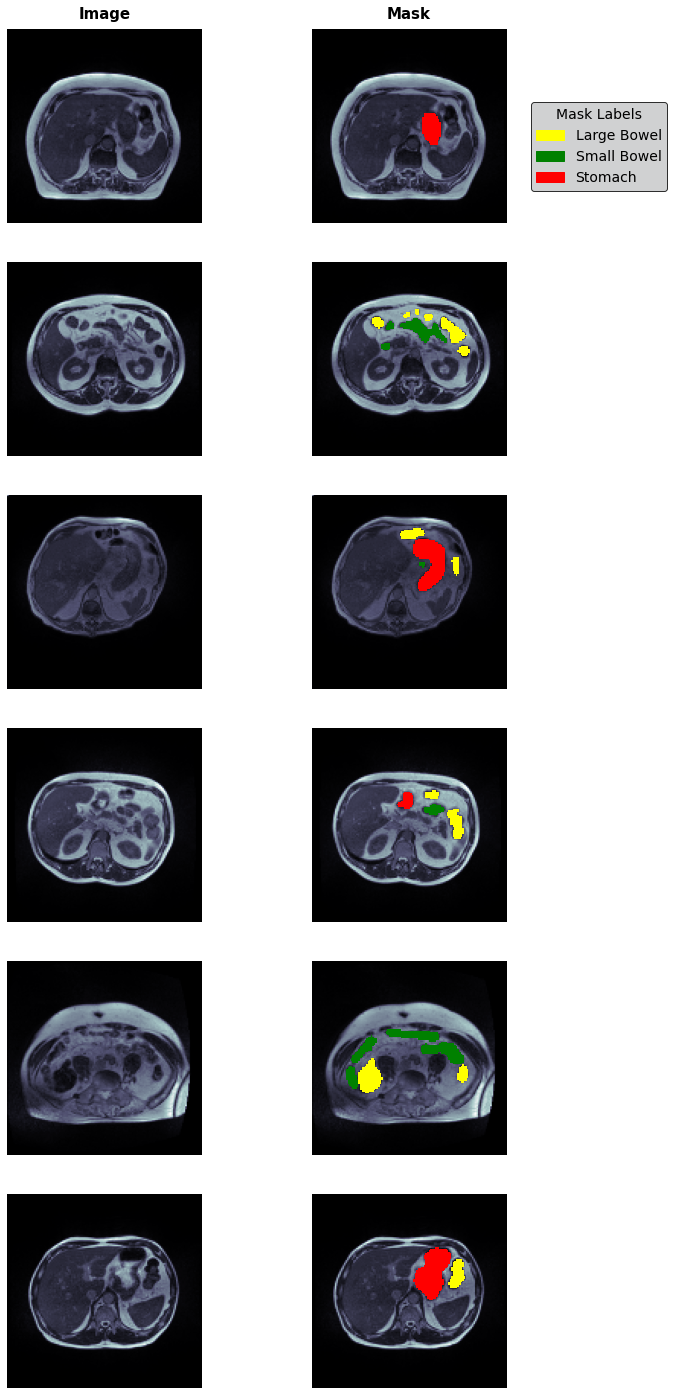

In [ ]:
# SAMPLES
Masks = list(train_df[train_df['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(train_df[train_df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(train_df[train_df['stomach']!=''].sample(BATCH_SIZE*3).index)

# DATA GENERATOR
View_batches = DataGenerator(train_df[train_df.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

In [ ]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

fold
1    8320
2    8288
3    7712
4    7120
5    7056
dtype: int64

In [ ]:
display(df_train.groupby(['fold','count'])['id'].count())

fold  count
1     0        4783
      1         557
      2        2350
      3         630
2     0        4756
      1         354
      2        2418
      3         760
3     0        4514
      1         604
      2        1983
      3         611
4     0        3923
      1         511
      2        2089
      3         597
5     0        3966
      1         432
      2        2070
      3         588
Name: id, dtype: int64

In [ ]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable


# model = Unet('resnet34',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
# model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[dice_coef,iou_coef]) 
# model.summary()

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   1728        ['input_9[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 64)   0           ['stem_bn[0][0]']         

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])
# Training generator
datagen = ImageDataGenerator( 
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=40,
    zoom_range = 0.1,
    rescale=1./255,
    validation_split=0.33)


In [ ]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)
history = model.fit(
    train_generator,
    validation_data= val_generator,
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS,
    callbacks=[reduce_lr,checkpoint,early_stopping]
    
)
# history = model.fit(
#     datagen.flow(train_generator),
#     validation_data= datagen.flow(val_generator),
#     use_multiprocessing=False,
#     workers=4,
#     epochs=EPOCHS,
#     callbacks=[reduce_lr,checkpoint,early_stopping]
    
# )

Epoch 1/10
1888/1888 [==============================] - ETA: 0s - loss: 0.2378 - dice_coef: 0.5900 - iou_coef: 0.3728
Epoch 1: val_loss improved from inf to 0.34340, saving model to UNET_model
INFO:tensorflow:Assets written to: UNET_model/assets
1888/1888 [==============================] - 902s 461ms/step - loss: 0.2378 - dice_coef: 0.5900 - iou_coef: 0.3728 - val_loss: 0.3434 - val_dice_coef: 0.3492 - val_iou_coef: 0.4456 - lr: 0.0010
Epoch 2/10
1888/1888 [==============================] - ETA: 0s - loss: 0.1303 - dice_coef: 0.7641 - iou_coef: 0.6497
Epoch 2: val_loss improved from 0.34340 to 0.26525, saving model to UNET_model
INFO:tensorflow:Assets written to: UNET_model/assets
1888/1888 [==============================] - 866s 459ms/step - loss: 0.1303 - dice_coef: 0.7641 - iou_coef: 0.6497 - val_loss: 0.2652 - val_dice_coef: 0.5109 - val_iou_coef: 0.7355 - lr: 0.0010
Epoch 3/10
1888/1888 [==============================] - ETA: 0s - loss: 0.1116 - dice_coef: 0.7984 - iou_coef: 0.715

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

In [ ]:
hist_df.head(10)

,loss,dice_coef,iou_coef,val_loss,val_dice_coef,val_iou_coef,lr
0,0.237786,0.590020,0.372811,0.343404,0.349234,0.445594,0.001
1,0.130328,0.764131,0.649709,0.265247,0.510892,0.735524,0.001
2,0.111610,0.798374,0.715021,0.317947,0.396721,0.565501,0.001
3,0.102803,0.814186,0.748803,0.304742,0.428689,0.668703,0.001
4,0.094079,0.829875,0.779016,0.255302,0.527438,0.739663,0.001
5,0.088177,0.840637,0.794536,0.301923,0.434639,0.672909,0.001
6,0.085633,0.845402,0.808843,0.278955,0.476180,0.700658,0.001
7,0.081021,0.853481,0.815780,0.246317,0.542495,0.750953,0.001
8,0.078891,0.857353,0.824518,0.243891,0.547726,0.749337,0.001
9,0.075356,0.863616,0.834756,0.260495,0.519577,0.731750,0.001


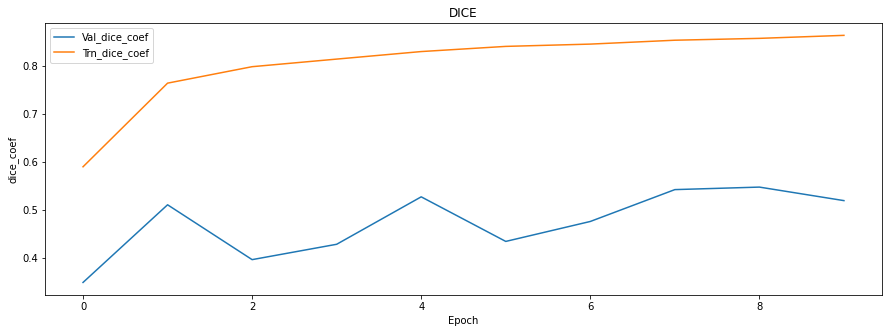

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

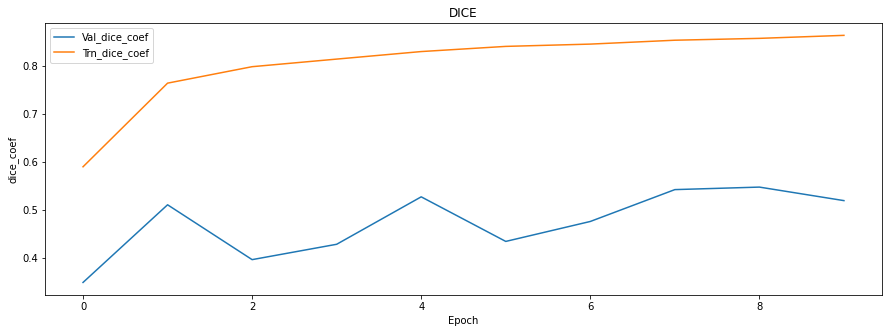

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

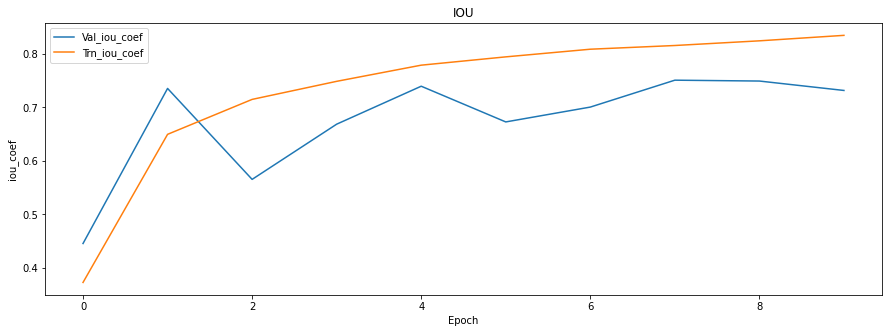

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend(); 
plt.show()

In [ ]:
# custom_objects = custom_objects={
#     'dice_coef': dice_coef,
#     'iou_coef': iou_coef,
#     'bce_dice_loss': bce_dice_loss  
# }
# model = load_model('./model.h5', custom_objects=custom_objects)

from keras.models import load_model, save_model
save_model(model,'UNET_model')

INFO:tensorflow:Assets written to: UNET_model/assets


In [ ]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

In [ ]:
pred_batches = DataGenerator(df_train.iloc[800:808,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 0s 13ms/step


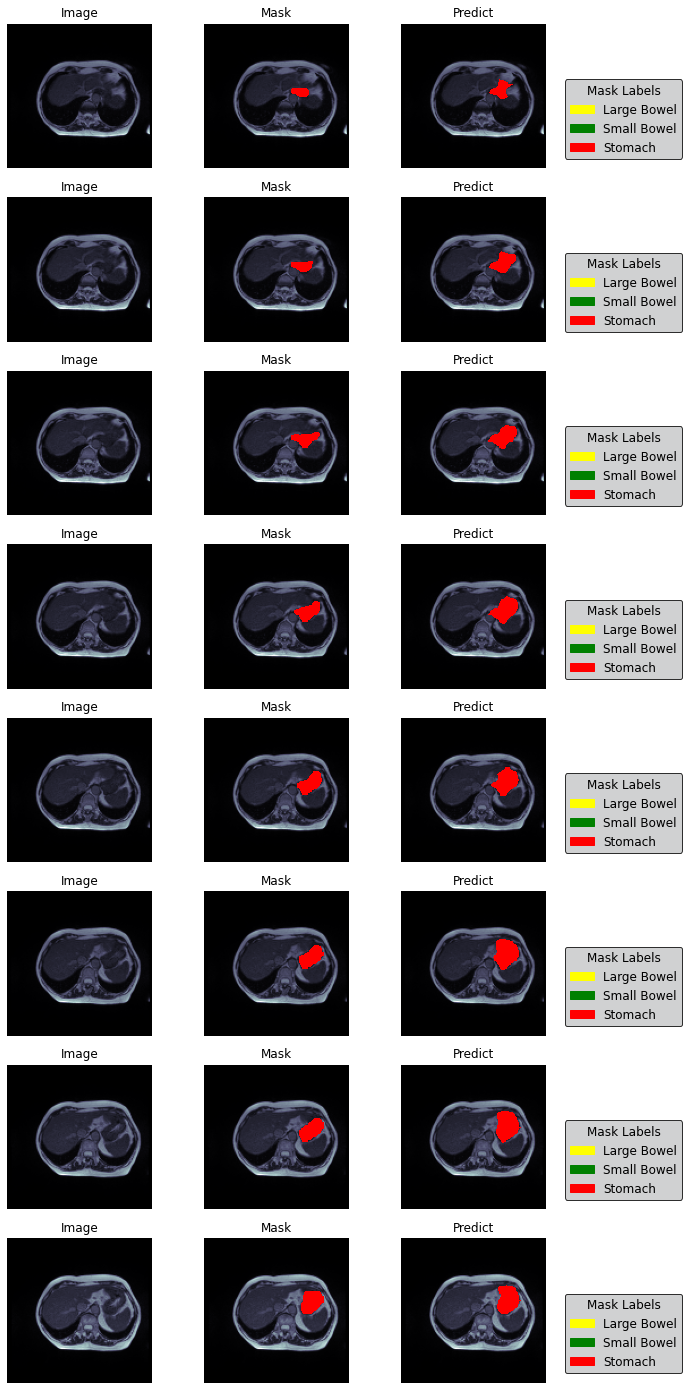

In [ ]:
Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')

In [ ]:
preds = model.predict_generator(val_generator,verbose=1)

518/518 [==============================] - 29s 55ms/step


In [ ]:
range(8)

range(0, 8)

In [ ]:
BATCH_SIZE

16

In [ ]:
test_df = df_train[df_train.index.isin(valid_ids)]
val_generator = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(val_generator)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(val_generator[i],verbose=0)     # shape: (16,128,128,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            print('**********************************')
            pred_img = cv2.resize(preds[j,:,:,k], (df_train.loc[i*BATCH_SIZE+j,"width"], df_train.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)

In [ ]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)

In [ ]:
!cp /content/model.h5 /content/drive/MyDrive/UW_Madison_segmentation/Unet/model.h5